# **Momentum variance of heavy quarks immersed in the Glasma**

Default simulation parameters chosen for a Glasma formed in $\mathrm{PbPb}$ collisions at $5.02\,\mathrm{TeV}$. Charm quarks formed at $\tau_\mathrm{form}=0.06\,\mathrm{fm/c}$ are placed in the Glasma and their subsequent dynamics is evolved via Wong's equations. All the quarks are provided with the same transverse momentum $p_T=0.5\,\mathrm{GeV}$ but a $\mathrm{FONLL}$ initialization is also implemented. 


In [1]:
import numpy as np

# General parameters
su_group = 'su2'        # Gauge group
system = 'PbPb'         # Pb-Pb or pPb
folder = 'pb+pb_5020gev_su2_pT_0.5_charm'      # Results folder

# Simulation box parameters
L = 10      # Length of simulation box [fm]
N = 512     # Number of lattice sites
tau_s = 2.0     # Simulation time [fm/c]
DTS = 8     # Time step

# MV model parameters for Pb-Pb at 5.02 TeV
A = 207     # Mass number
sqrts = 5020        # Center-of-mass energy [GeV]
ns = 50     # Number of color sheets
factor = 0.8        # Ratio between Qs/g^2\mu for Ns = 50 color sheets
Qs = np.sqrt(0.13 * A**(1/3) * sqrts**0.25)         # Saturation momentum [GeV]	
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))           # Running coupling constant		
mu = Qs / (g**2 * factor)           # MV model parameter	
m = 0.1 * g**2 * mu         # Infrared regulator [GeV]
uv = 10.0           # Ultraviolet regulator [GeV]

# Heavy quark related parameters, chosen here for a charm quark
quark = 'charm'     # Quark type
mass = 1.5      # Heavy quark mass [GeV]
tau_form = 0.06     # Formation time [fm/c]
nq = 15     # Number of heavy quark antiquark pairs
pT = 0.5    # Initial transverse momentum [GeV]
ntp = 10   # Number of test particles
FONLL = False   # FONLL initial momentum distribution

# Other numerical parameters
nevents = 10    # Number of Glasma events
solveq = 'wilson_lines'     # Solve the equation for the color charge with Wilson lines or gauge potentials
frame = 'milne'         # Milne coordinates or laboratory frame
NUM_CHECKS = True       # Perform numerical checks (compute Casimirs, for example)
FORCE_CORR = False      # Compute the Lorentz force correlator along the trajectory of the heavy quarks

Dictionary with standard MV model paramaters.

In [2]:
p = {
    # General parameters
    'GROUP':    su_group,       # SU(2) or SU(3) group
    'FOLDER':   folder,         # results folder
    'SYSTEM':   system,         # collision system

    # Parameters for simulation box
    'L':    L,           # transverse size [fm]
    'N':    N,            # lattice size
    'DTS':  DTS,             # time steps per transverse spacing
    'TMAX': tau_s,          # max. proper time (tau) [fm/c]

    # Parameters for MV model
    'G':    g,            # YM coupling constant
    'MU':   mu,             # MV model parameter [GeV]
    'M':    m,              # IR regulator [GeV]
    'UV':   uv,           # UV regulator [GeV]
    'NS':   ns,             # number of color sheets
    
    # Parameters for heavy quarks
    'MASS': mass,           # mass of HQ [GeV]
    'TFORM': tau_form,       # formation time of the HQ [fm/c]
    'PT': pT,           # transverse momentum of HQs [GeV]
    'NQ': nq,         # number of heavy quarks
    'NTP': ntp,         # number of test particles
    'FONLL': FONLL,     # FONLL pQCD initialization

    # Numerical parameters
    'NEVENTS': nevents,     # number of Glasma events
    'SOLVEQ': solveq,       # method used to solve the equation for color charge
    'FRAME': frame,         # laboratory of Milne frame
    'NUM_CHECKS': NUM_CHECKS,    # perform numerical checks
    'FORCE_CORR': FORCE_CORR,   # compute correlator of Lorentz force
}

# Option to solve in laboratory frame with Boris push only for solution of color charge equation with Wilson lines, with no numerical checks or force correlator computation
if p['FRAME']=='lab':
    p['SOLVEQ']='wilson lines'
    p['FORCE_CORR']=False
    p['FONLL']=False

Set environment variables.

In [3]:
# Set environment variables 
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
if p['GROUP'] == 'su2':
    os.environ["GAUGE_GROUP"] = 'su2_complex'
elif p['GROUP'] == 'su3':
    os.environ["GAUGE_GROUP"] = p['GROUP']


# Import relevant modules
import sys
sys.path.append('..')
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda
if p['FRAME']=='milne':
    from curraun.wong_hq_batch import initial_coords, initial_momenta, initial_charge, solve_wong, initial_momenta_fonll
elif p['FRAME']=='lab':
    from curraun.wong_hq_lab import initial_coords, initial_momenta, initial_charge, solve_wong

# Define hbar * c in units of GeV * fm
hbarc = 0.197326 

Using CUDA
Using SU(2) complex
Using double precision
Using double precision


Simulation function.

In [4]:
def simulate(p, ev, inner_loop): 
   
    xmu, pmu = {}, {}
    xmu0, pmu0, q0, xmu1, pmu1, q1 = {}, {}, {}, {}, {}, {}
    fields, charge = {}, {}
    # If NUM_CHECKS = True
    constraint, casimirs = {}, {}
    # If FORCE_CORR = True
    correlators = {}
    correlators['EformE'], correlators['FformF'] = {}, {}
    tags_corr = ['naive', 'transported']
    for tag in tags_corr:
        correlators['EformE'][tag], correlators['FformF'][tag] = {}, {}
    fieldsform = {}
    fieldsform['E'], fieldsform['F'] = {}, {}
    electric_fields, lorentz_force, force_correlators = {}, {}, {}

    # Derived parameters
    a = p['L'] / p['N']
    E0 = p['N'] / p['L'] * hbarc
    p['E0'] = E0
    DT = 1.0 / p['DTS']
    formt = int(p['TFORM'] / a * p['DTS'])

    s = core.Simulation(p['N'], DT, p['G'])
    va = mv.wilson(s, mu=p['MU'] / E0, m=p['M'] / E0, uv=p['UV'] / E0, num_sheets=p['NS'])
    vb = mv.wilson(s, mu=p['MU'] / E0, m=p['M'] / E0, uv=p['UV'] / E0, num_sheets=p['NS'])
    initial.init(s, va, vb)

    if use_cuda:
        s.copy_to_device()

    for t in range(len(inner_loop)):
        core.evolve_leapfrog(s)

        if t>=formt:  
            if p['FONLL']:
                initial_momenta_fonll(p)
                pt, N = p['PTFONLL'], p['NFONLL']
                for ipt in range(len(pt)):
                    p['PT'] = pt[ipt]
                    for ip in range(N[ipt]):
                        tagq = 'ev_' + str(ev+1) + '_q_' + str(ipt+1) + '_n_' + str(ip+1)
                        tagaq = 'ev_' + str(ev+1) + '_aq_' + str(ipt+1) + '_n_' + str(ip+1)
                        tags = [tagq, tagaq]

                        if t==formt:
                            # Initialize quark
                            xmu0[tagq] = initial_coords(p)
                            pmu0[tagq] = initial_momenta(p)
                            q0[tagq] = initial_charge(p)

                            # Initialize antiquark
                            xmu0[tagaq] = xmu0[tagq]
                            pmu0[tagaq] = [pmu0[tagq][0], -pmu0[tagq][1], -pmu0[tagq][2], pmu0[tagq][3]]
                            q0[tagaq] = initial_charge(p)

                            for tag in tags:
                                solve_wong(s, p, t, xmu0[tag], pmu0[tag], q0[tag], xmu, pmu, fields, charge, tag, constraint, casimirs, correlators, fieldsform, electric_fields, lorentz_force, force_correlators)

                        elif t>formt:
                            for tag in tags:
                                xmu1[tag], pmu1[tag], q1[tag] = solve_wong(s, p, t, xmu0[tag], pmu0[tag], q0[tag], xmu, pmu, fields, charge, tag, constraint, casimirs, correlators, fieldsform, electric_fields, lorentz_force, force_correlators)
                                # Swap x, p, q for next time step
                                xmu0[tag], pmu0[tag], q0[tag] = xmu1[tag], pmu1[tag], q1[tag]

            else:
                for q in range(p['NQ']):
                    for tp in range(p['NTP']):

                        tagq = 'ev_' + str(ev+1) + '_q_' + str(q+1) + '_tp_' + str(tp+1)
                        tagaq = 'ev_' + str(ev+1) + '_aq_' + str(q+1) + '_tp_' + str(tp+1)
                        tags = [tagq, tagaq]

                        if t==formt:
                            # Initialize quark
                            xmu0[tagq] = initial_coords(p)
                            pmu0[tagq] = initial_momenta(p)
                            q0[tagq] = initial_charge(p)

                            # Initialize antiquark
                            xmu0[tagaq] = xmu0[tagq]
                            pmu0[tagaq] = [pmu0[tagq][0], -pmu0[tagq][1], -pmu0[tagq][2], pmu0[tagq][3]]
                            q0[tagaq] = initial_charge(p)

                            for tag in tags:
                                solve_wong(s, p, t, xmu0[tag], pmu0[tag], q0[tag], xmu, pmu, fields, charge, tag, constraint, casimirs, correlators, fieldsform, electric_fields, lorentz_force, force_correlators)

                        elif t>formt:
                            for tag in tags:
                                xmu1[tag], pmu1[tag], q1[tag] = solve_wong(s, p, t, xmu0[tag], pmu0[tag], q0[tag], xmu, pmu, fields, charge, tag, constraint, casimirs, correlators, fieldsform, electric_fields, lorentz_force, force_correlators)
                                # Swap x, p, q for next time step
                                xmu0[tag], pmu0[tag], q0[tag] = xmu1[tag], pmu1[tag], q1[tag]

        inner_loop.update()

    if use_cuda:
        s.copy_to_host()
        cuda.current_context().deallocations.clear()

    if p['FONLL']:
        for ipt in range(len(pt)):
            for ip in range(N[ipt]):
                tagq = 'ev_' + str(ev+1) + '_q_' + str(ipt+1) + '_n_' + str(ip+1)
                tagaq = 'ev_' + str(ev+1) + '_aq_' + str(ipt+1) + '_n_' + str(ip+1)
                tags = [tagq, tagaq]

                for tag in tags:
                    output = {}
                    output['xmu'], output['pmu'] = xmu[tag], pmu[tag]
                    if p['NUM_CHECKS']:
                        output['constraint'], output['casimirs'] = constraint[tag], casimirs[tag]
                    if p['FORCE_CORR']:
                        output['correlators'] = {}
                        types_corr = ['EformE', 'FformF']
                        tags_corr = ['naive', 'transported']
                        for type_corr in types_corr:
                            output['correlators'][type_corr] = {}
                            for tag_corr in tags_corr:
                                output['correlators'][type_corr][tag_corr] = correlators[type_corr][tag_corr][tag]    

                    filename = tag + '.pickle'
                    with open(filename, 'wb') as handle:
                        pickle.dump(output, handle)

    else:
        for q in range(p['NQ']):
            for tp  in range(p['NTP']):
                tagq = 'ev_' + str(ev+1) + '_q_' + str(q+1) + '_tp_' + str(tp+1)
                tagaq = 'ev_' + str(ev+1) + '_aq_' + str(q+1) + '_tp_' + str(tp+1)
                tags = [tagq, tagaq]

                for tag in tags:
                    output = {}
                    output['xmu'], output['pmu'] = xmu[tag], pmu[tag]
                    if p['NUM_CHECKS']:
                        output['constraint'], output['casimirs'] = constraint[tag], casimirs[tag]
                    if p['FORCE_CORR']:
                        output['correlators'] = {}
                        types_corr = ['EformE', 'FformF']
                        tags_corr = ['naive', 'transported']
                        for type_corr in types_corr:
                            output['correlators'][type_corr] = {}
                            for tag_corr in tags_corr:
                                output['correlators'][type_corr][tag_corr] = correlators[type_corr][tag_corr][tag]    

                    output['parameters'] = p
                    filename = tag + '.pickle'
                    with open(filename, 'wb') as handle:
                        pickle.dump(output, handle)

    with open('parameters.pickle', 'wb') as handle:
        pickle.dump(p, handle)

    return output

Create folders to store the files resulting from the simulations


In [5]:
import pickle

current_path = os.getcwd() 
results_folder = 'results'
check_results_folder = os.path.isdir(results_folder)
if not check_results_folder:
    os.makedirs(results_folder)
results_path = current_path + '/' + results_folder + '/'
os.chdir(results_path)

wong_folder = p['FOLDER']
check_wong_folder = os.path.isdir(wong_folder)
if not check_wong_folder:
    os.makedirs(wong_folder)
wong_path = results_path + '/' + wong_folder + '/'
os.chdir(wong_path)

# Save parameters dictionary to file
with open('parameters.pickle', 'wb') as handle:
    pickle.dump(p, handle)

Simulate multiple Glasma events, each event with 15 quarks and 15 antiquarks, produced at the same positions as the quarks, having opposite momenta and random charge. The number of quarks or antiquarks is enlarged by a given number of test particles.


In [6]:
from tqdm.notebook import tqdm

outer_loop=tqdm(range(p['NEVENTS']), desc="Event", position=0)
inner_loop=tqdm(range(int(p['TMAX'] / (p['L'] / p['N']) * p['DTS'])), desc="Time", position=1)

for ev in range(len(outer_loop)):
    simulate(p, ev, inner_loop)
    if (ev+1)<len(outer_loop):
        inner_loop.refresh()  
        inner_loop.reset()
    outer_loop.update() 

Event:   0%|          | 0/10 [00:00<?, ?it/s]

Time:   0%|          | 0/819 [00:00<?, ?it/s]

Read the results from files and compute averages.

In [7]:
def average(wong_path,p):
    average = {}
    x, y = [], []
    px, py = [], []

    taui = 0

    if p['FORCE_CORR']:
        tags = ['naive', 'transported']
        all_EformE, all_FformF = {}, {}
        for tag in tags:
            all_EformE[tag] = []
            all_FformF[tag] = []

    for file in os.listdir(wong_path):
        if file.startswith("ev_"):
            data = pickle.load(open(file, 'rb'))
            x.append(np.array(data['xmu'])[:, 1])
            y.append(np.array(data['xmu'])[:, 2])
            px.append(np.array(data['pmu'])[:, 1])
            py.append(np.array(data['pmu'])[:, 2])

            if taui==0:
                average['tau']=np.array(data['xmu'])[:, 0]
                taui = taui+1

            if p['FORCE_CORR']:
                for tag in tags:
                    all_EformE[tag].append(data['correlators']['EformE'][tag])
                    all_FformF[tag].append(data['correlators']['FformF'][tag])


    time_steps = np.array(px).shape[1]

    sigmaxt, sigmapt = [], []

    for i in range(1, time_steps):
        sigmaxt.append(((np.array(x)[:, i]-np.array(x)[:, 0]) ** 2+(np.array(y)[:, i]-np.array(y)[:, 0]) ** 2)/2)
        sigmapt.append(((np.array(px)[:, i]-np.array(px)[:, 0]) ** 2+(np.array(py)[:, i]-np.array(py)[:, 0]) ** 2)/2)

    nsamples = np.array(sigmapt).shape[1]
    average['sigmaxt_mean'], average['sigmaxt_std'] = np.mean(sigmaxt, axis=1), np.std(sigmaxt, axis=1) / np.sqrt(nsamples)
    average['sigmapt_mean'], average['sigmapt_std'] = np.mean(sigmapt, axis=1), np.std(sigmapt, axis=1) / np.sqrt(nsamples)

    if p['FORCE_CORR']:
        average['mean_EformE'], average['std_EformE'], average['mean_FformF'], average['std_FformF'] = {}, {}, {}, {}
        for tag in tags:
            average['mean_EformE'][tag], average['std_EformE'][tag] = np.mean(all_EformE[tag], axis=0), np.std(all_EformE[tag], axis=0)
            average['mean_FformF'][tag], average['std_FformF'][tag] = np.mean(all_FformF[tag], axis=0), np.std(all_FformF[tag], axis=0)

    filename = 'avg.pickle'
    with open(filename, 'wb') as handle:
        pickle.dump(average, handle)

check_file_avg = os.path.isfile('avg.pickle')
average(wong_path,p)
if not check_file_avg:
    average(wong_path, p)
data = pickle.load(open('avg.pickle', 'rb'))
sigmaxt_mean, sigmaxt_std, sigmapt_mean, sigmapt_std, tau = data['sigmaxt_mean'], data['sigmaxt_std'], data['sigmapt_mean'], data['sigmapt_std'], data['tau']

Plot the momentum variance and zoom in at very early proper times.

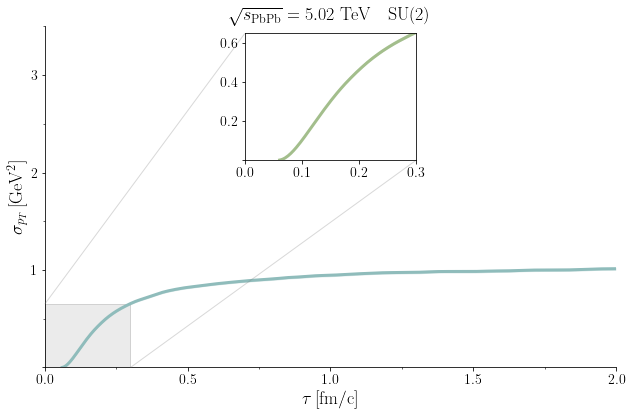

In [8]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams.update({'font.size':14})

fig = plt.figure()
ax = plt.subplot()

plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 18)
plt.ylabel(r'$\sigma_{p_T}\,\mathrm{[GeV^2]}$', size = 18)
if su_group=='su2':
    plt.title(r'$\sqrt{s_\mathrm{PbPb}}=5.02\,\,\mathrm{TeV}\quad\mathrm{SU}(2)$', size=18)
elif su_group=='su3':
    plt.title(r'$\sqrt{s_\mathrm{PbPb}}=5.02\,\,\mathrm{TeV}\quad\mathrm{SU}(3)$', size=18)

ax.set_xlim(0,2)
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.yaxis.get_major_ticks()[1].label1.set_visible(False)

ax.plot(tau[1:len(tau)], sigmapt_mean, '-', color = '#8FBCBB', markersize = 0, linewidth = 3)
ax.fill_between(tau[1:len(tau)], sigmapt_mean-sigmapt_std/2, sigmapt_mean+sigmapt_std/2, color = '#8FBCBB', alpha=0.3)

axins = zoomed_inset_axes(ax,2,loc='upper center')
axins.yaxis.get_major_ticks()[1].label1.set_visible(False)

axins.plot(tau[1:len(tau)], sigmapt_mean, '-', color = '#A3BE8C', markersize = 0, linewidth = 3)
axins.fill_between(tau[1:len(tau)], sigmapt_mean-sigmapt_std/2, sigmapt_mean+sigmapt_std/2, color = '#A3BE8C', alpha=0.3)

if p['GROUP']=='su2':
    ax.set_ylim(0,3.5)
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    axins.xaxis.set_major_locator(MultipleLocator(0.1))
    axins.yaxis.set_major_locator(MultipleLocator(0.2))
    x1,x2,y1,y2 = 0, 0.3, 0, 0.65
elif p['GROUP']=='su3':
    ax.set_ylim(0,10.0)
    ax.yaxis.set_major_locator(MultipleLocator(4))
    ax.yaxis.set_minor_locator(MultipleLocator(2))
    axins.xaxis.set_major_locator(MultipleLocator(0.1))
    axins.yaxis.set_major_locator(MultipleLocator(0.5))
    x1,x2,y1,y2 = 0, 0.3, 0, 1.9

axins.set_xlim(x1,x2)
axins.set_ylim(y1,y2)

mark_inset(ax,axins,loc1=2,loc2=4, color='gray', alpha=0.3, fc='silver')

plt.tight_layout()

Plot the proper time evolution for the values of the Casimirs, whose values should be $\mathscr{C}_2=3/4$ for $\mathrm{SU(2)}$ and $\mathscr{C}_2=4/3$ with $\mathscr{C}_3=10/9$ for $\mathrm{SU(3)}$.

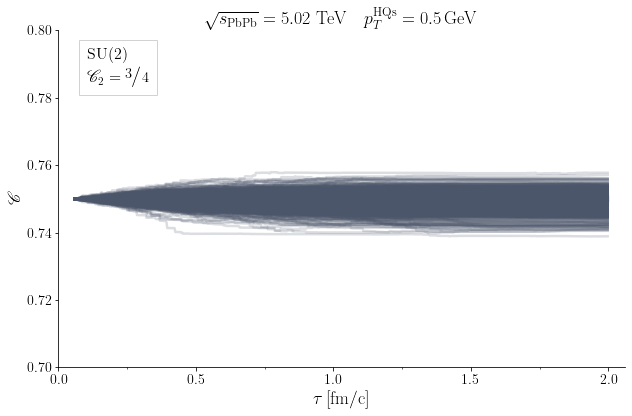

In [11]:
plt.rcParams['text.latex.preamble'] = [r'\usepackage{xfrac}', r'\usepackage{mathrsfs}']

fig = plt.figure()
ax = plt.subplot()

plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 18)
plt.ylabel(r'$\mathscr{C}$', size = 18)

ax.set_xlim(0,2.06)
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))

if su_group=='su2':
    plt.title(r'$\sqrt{s_\mathrm{PbPb}}=5.02\,\,\mathrm{TeV}\quad p_T^{\mathrm{HQs}}=0.5\,\mathrm{GeV}$', size = 18)
    ax.set_ylim(0.7,0.8)
    textstr = '\n'.join((
        r'${\huge\mathrm{SU(2)}}$',
        r'$\mathscr{C}_2={\huge\sfrac{3}{\,4}}$',
    ))
    pltcolorc2 = '#4C566A'

elif su_group=='su3':
    plt.title(r'$\sqrt{s_\mathrm{PbPb}}=5.02\,\,\mathrm{TeV}\quad p_T^{\mathrm{HQs}}=0.5\,\mathrm{GeV}$', size = 18)
    ax.set_ylim(0.1, 2.5)
    ax.yaxis.set_major_locator(MultipleLocator(0.8))
    ax.yaxis.set_minor_locator(MultipleLocator(0.4))
    textstr = '\n'.join((
        r'${\huge\mathrm{SU(3)}}$',
        r'$\mathscr{C}_2={\huge\sfrac{4}{\,3}}$',
        r'$\mathscr{C}_3={\huge\sfrac{10}{\,9}}$',
    ))
    pltcolorc2, pltcolorc3 = '#4C566A', '#2E3440'

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

taui = 0
for file_name in os.listdir(wong_path):
    if file_name.startswith('ev_'):
        file_path = wong_path + file_name
        data = pickle.load(open(file_path, 'rb'))
        qsq = np.array(data['casimirs'])
        if taui==0:
            tau = np.array(data['xmu'])[:, 0]
            taui = taui+1
            if su_group=='su3':
                plt.plot(tau, -1*qsq[:, 0], '-', color = pltcolorc2, markersize = 0, linewidth = 2.5, label=r'$\mathcal{C}_2$')
                plt.plot(tau, -1*qsq[:, 1], '-', color = pltcolorc3, markersize = 0, linewidth = 2.5, label=r'$\mathcal{C}_3$')
        if su_group=='su2':
            plt.plot(tau, qsq, '-', color = pltcolorc2, markersize = 0, linewidth = 2.5, alpha=0.2)
        elif su_group=='su3':
            plt.plot(tau, qsq[:, 0], '-', color = pltcolorc2, markersize = 0, linewidth = 2.5, alpha=0.1)
            plt.plot(tau, qsq[:, 1], '-', color = pltcolorc3, markersize = 0, linewidth = 2.5, alpha=0.1)

props = dict(boxstyle='square', facecolor='white', alpha=0.7, edgecolor='silver', pad=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=16, verticalalignment='top', bbox=props)

if su_group=='su3':
    leg = ax.legend(fontsize = 16, loc = 'upper right', ncol=2, bbox_to_anchor=(0.98,0.98))
    leg.get_frame().set_boxstyle('square')

plt.tight_layout()

Plot the relative difference for the temporal component of the momentum $p^\tau$ as a function of proper time, computed in two different ways: either from the norm of the four-momentum as $p^\tau=\sqrt{(p^x)^2+(p^y)^2+\tau^2 (p^\eta)^2+m^2}$ or by numerically solving the corresponding Wong equation $p^\tau\dfrac{\mathrm{d}p^\tau}{\mathrm{d}\tau}+\tau(p^\eta)^2=2g\left(\mathsf{Tr}\{Q E_\eta\} \tau p^\eta+\mathsf{Tr}\{QE_x\} p^x+\mathsf{Tr}\{QE_y\} p^y\right)$, which esentially represents the conservation of energy. This is a numerical check for the methods used to evolve the momenta.

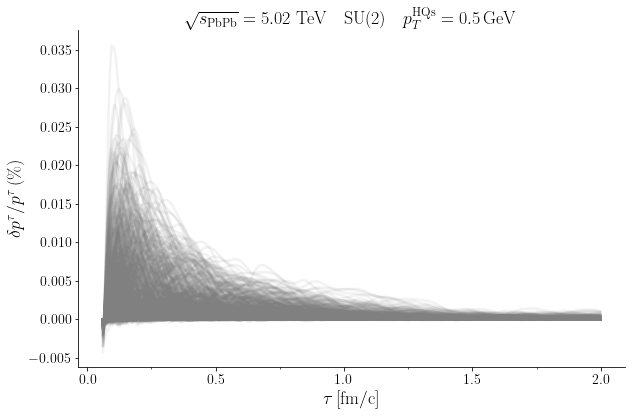

In [12]:
fig = plt.figure()
ax = plt.subplot()

plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 18)
plt.ylabel(r'$\delta p^\tau/p^\tau\,(\%)$', size = 18)
if su_group=='su2':
    plt.title(r'$\sqrt{s_\mathrm{PbPb}}=5.02\,\,\mathrm{TeV}\quad\mathrm{SU}(2)\quad p_T^{\mathrm{HQs}}=0.5\,\mathrm{GeV}$', size=18)
elif su_group=='su3':
    plt.title(r'$\sqrt{s_\mathrm{PbPb}}=5.02\,\,\mathrm{TeV}\quad\mathrm{SU}(3)\quad p_T^{\mathrm{HQs}}=0.5\,\mathrm{GeV}$', size=18)

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

taui = 0
for file_name in os.listdir(wong_path):
    if file_name.startswith('ev_1'):
        file_path = wong_path + file_name
        data = pickle.load(open(file_path, 'rb'))
        delta_ptau = data['constraint']
        ptau = np.array(data['pmu'])[:, 0]
        deltaptau_ptau = np.divide(delta_ptau, ptau[1:len(ptau)])
        if taui==0:
            tau = np.array(data['xmu'])[:, 0]
            taui = taui+1
        plt.plot(tau[1:len(tau)], deltaptau_ptau, '-', color = 'gray', markersize = 0, linewidth = 2.5, alpha=0.1)

plt.tight_layout()

After the same script is used to run simulations also for $p_T\in\{5,10\}\,\mathrm{GeV}$ initial momenta of the charm quarks by simply changing `pT=5.0` and `pT=10.0` where the initial simulation parameters are set, compute the averages in order to extract the momentum variances.

In [13]:
pTs = [0.5, 5.0, 10.0]
sigmapt_mean, sigmapt_std = {}, {}

for pT in pTs:
    wong_folder = 'pb+pb_5020gev_su2_pT_' + str(pT) + '_charm'
    wong_path = results_path + wong_folder + '/' 
    os.chdir(wong_path)
    check_file_avg = os.path.isfile('avg.pickle')
    if not check_file_avg:
        average(wong_path, p)
    data = pickle.load(open('avg.pickle', "rb"))
    sigmapt_mean[str(pT)], sigmapt_std[str(pT)], tau = data['sigmapt_mean'], data['sigmapt_std'], data['tau']

Plot the momentum variances corresponding to these different toy initialization with all heavy quarks having initial $p_T\in\{0.5, 5,10\}\,\mathrm{GeV}$, as they evolve in proper time.

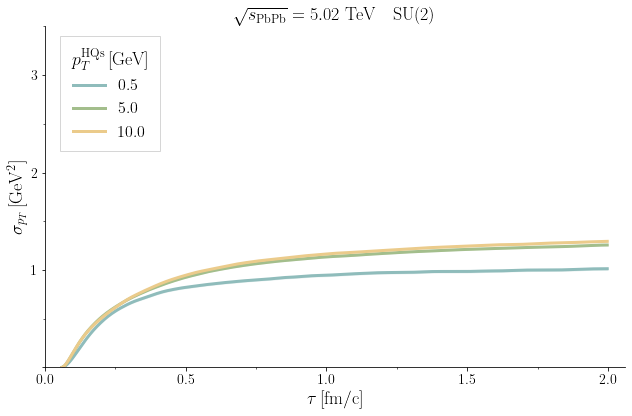

In [14]:
fig = plt.figure()
ax = plt.subplot()

plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 18)
plt.ylabel(r'$\sigma_{p_T}\,\mathrm{[GeV^2]}$', size = 18)
if su_group=='su2':
    plt.title(r'$\sqrt{s_\mathrm{PbPb}}=5.02\,\,\mathrm{TeV}\quad\mathrm{SU}(2)$', size=18)
elif su_group=='su3':
    plt.title(r'$\sqrt{s_\mathrm{PbPb}}=5.02\,\,\mathrm{TeV}\quad\mathrm{SU}(3)$', size=18)

ax.set_xlim(0,2.06)
ax.set_ylim(0,3.5)

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.yaxis.get_major_ticks()[1].label1.set_visible(False)


colors = ['#8FBCBB', '#A3BE8C', '#EBCB8B']
pTs = [0.5, 5.0, 10.0]
labels = [r'$0.5$', r'$5.0$', r'$10.0$']

i = 0
for pT in pTs:
    ax.plot(tau[1:len(tau)], sigmapt_mean[str(pT)], '-', color = colors[i], markersize = 0, linewidth = 3, label=labels[i])
    ax.fill_between(tau[1:len(tau)], sigmapt_mean[str(pT)]-sigmapt_std[str(pT)]/2, sigmapt_mean[str(pT)]+sigmapt_std[str(pT)]/2, color = colors[i], alpha=0.2)
    i=i+1

leg = ax.legend(fontsize = 16, loc = 'upper left', bbox_to_anchor=(0.02,0.98))
leg.get_frame().set_boxstyle('square')
leg.set_title(r'$p_T^\mathrm{HQs}\,\mathrm{[GeV]}$',prop={'size':18})

plt.tight_layout()

Run the above script replacing `solveq='gauge_potentials'` together with `frame='milne'` and `solveq='wilson_lines'` with `frame='lab'` and then perform the averages. Plot of a comparison in momentum variance between different numerical methods: using Wilson lines to solve the equation for the color charge and Euler to update the momenta, employing a solution for the color charge in terms of gauge potentials numerically extracted from gauge links on the lattice and also Euler for momentum update or a combination of Wilson lines for color charge evolution and the Boris push for the momentum equations (solved in the laboratory frame since in the Milne coordinates this method may not be applied).

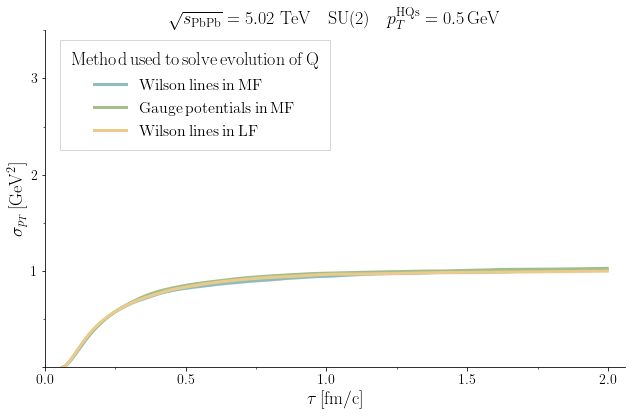

In [16]:
fig = plt.figure()
ax = plt.subplot()

plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 18)
plt.ylabel(r'$\sigma_{p_T}\,\mathrm{[GeV^2]}$', size = 18)
if su_group=='su2':
    plt.title(r'$\sqrt{s_\mathrm{PbPb}}=5.02\,\,\mathrm{TeV}\quad\mathrm{SU}(2)\quad p_T^{\mathrm{HQs}}=0.5\,\mathrm{GeV}$', size=18)
elif su_group=='su3':
    plt.title(r'$\sqrt{s_\mathrm{PbPb}}=5.02\,\,\mathrm{TeV}\quad\mathrm{SU}(3)\quad p_T^{\mathrm{HQs}}=0.5\,\mathrm{GeV}$', size=18)

ax.set_xlim(0,2.06)
ax.set_ylim(0,3.5)

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.yaxis.get_major_ticks()[1].label1.set_visible(False)

folders = ['pb+pb_5020gev_su2_pT_0.5_charm', 'pb+pb_5020gev_su2_pT_0.5_gauge_potentials_charm', 'pb+pb_5020gev_su2_pT_0.5_lab_charm']
colors = ['#8FBCBB', '#A3BE8C', '#EBCB8B']
labels = [r'$\mathrm{Wilson\,lines\,in\,MF}$', r'$\mathrm{Gauge\,potentials\,in\,MF}$', r'$\mathrm{Wilson\,lines\,in\,LF}$']
i=0

for wong_folder in folders:
    wong_path = results_path + wong_folder + '/' 
    os.chdir(wong_path)
    check_file_avg = os.path.isfile('avg.pickle')
    if not check_file_avg:
        average(wong_path, p)
    data = pickle.load(open('avg.pickle', "rb"))
    sigmapt_mean[str(pT)], sigmapt_std[str(pT)], tau = data['sigmapt_mean'], data['sigmapt_std'], data['tau']

    ax.plot(tau[1:len(tau)], sigmapt_mean[str(pT)], '-', color = colors[i], markersize = 0, linewidth = 3, label=labels[i])
    ax.fill_between(tau[1:len(tau)], sigmapt_mean[str(pT)]-sigmapt_std[str(pT)]/2, sigmapt_mean[str(pT)]+sigmapt_std[str(pT)]/2, color = colors[i], alpha=0.2)
    i=i+1

leg = ax.legend(fontsize = 16, loc = 'upper left', bbox_to_anchor=(0.02,0.98))
leg.get_frame().set_boxstyle('square')
leg.set_title(r'$\mathrm{Method\,used\,to\,solve\,evolution\,of\,Q}$',prop={'size':18})

plt.tight_layout()